In [1]:
!pip install nltk
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers pandas scikit-learn tqdm faker markovify joblib

Looking in indexes: https://download.pytorch.org/whl/cu121
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 54.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 16.9 MB/s eta 0:00:00
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18607 sha256=b62e909b9e70ba2c2439edc93f2db88ee8063bc696f21433ab65df884f9f25a7
  Stored in directory: /root/.cache/pip/wheels/ca/8c/c5/41413e24c484f883a100c63ca7b3b0362b7c6f6eb6d7c9cc7f
Successfully built markovify


In [2]:
!git clone https://github.com/egmaziero/cstparser.git
%cd cstparser

import sys
sys.path.append("/kaggle/working/cstparser")

!python -m nltk.downloader punkt
!python setup.py install

Cloning into 'cstparser'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53 (from 1)
Receiving objects: 100% (53/53), 1.48 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/kaggle/working/cstparser
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See 

In [3]:
!pip install cudf-cu12 cuml-cu12 cudatoolkit==12.1
!pip install cupy-cuda12x

ERROR: Could not find a version that satisfies the requirement cudatoolkit==12.1 (from versions: none)
ERROR: No matching distribution found for cudatoolkit==12.1


In [4]:
import pandas as pd  # Pandas library for data manipulation
from sklearn.model_selection import train_test_split  # Function for splitting datasets into training and testing sets
from jinja2 import Template
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import webbrowser
import os
from IPython.display import display, HTML
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
from faker import Faker
from itertools import product
from markovify import Text
from collections import Counter
from sklearn.neighbors import KernelDensity
import joblib

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
print(f"GPU disponível: {torch.cuda.is_available()}")
print(f"Versão do CUDA: {torch.version.cuda}")

GPU disponível: True
Versão do CUDA: 12.1


In [6]:
df = pd.read_csv("/kaggle/input/brazilian-headlines-sentiments/brazilian_headlines_sentiments.csv")

In [7]:
df

,Unnamed: 0,website,keywords,headlinePortuguese,headlineEnglish,sentimentScorePortuguese,sentimentScoreEnglish,sentimentMagnitudePortuguese,sentimentMagnitudeEnglish,isOnline,onlineStartDate,onlineEndDate,onlineTotalTimeMS
0,0,UOL,['Bolsonaro'],Bolsonaro se desculpa após mandar repórter 'ca...,Bolsonaro apologizes after telling reporter to...,0.0,-0.8,0.0,0.8,False,2020-05-05 23:03:18.646000+00:00,2020-05-06 02:31:21.888000+00:00,12483242.0
1,1,O Antagonista,['Bolsonaro'],"“Bolsonaro, faça um exame de consciência”","""Bolsonaro, take a conscience exam""",0.1,0.0,0.1,0.0,False,2020-06-21 00:05:50.133000+00:00,2020-06-21 12:32:13.907000+00:00,44783774.0
2,2,G1,"['Bolsonaro', 'Moro']",Moro dá 'unfollow' em Bolsonaro em rede social...,Moro gives 'unfollow' in Bolsonaro on social n...,0.0,-0.2,0.0,0.2,False,2020-04-27 14:02:24.664000+00:00,2020-04-27 19:03:05.930000+00:00,18041266.0
3,3,Folha de SP,['Bolsonaro'],Inquérito que investiga Bolsonaro adota 'sabat...,Inquiry investigating Bolsonaro adopts 'sabbat...,0.1,0.0,0.1,0.0,False,2020-06-08 11:32:21.009000+00:00,2020-06-08 15:31:21.470000+00:00,14340461.0
4,4,R7,['Weintraub'],Weintraub defendeu prisão para 'vagabundos' e ...,Weintraub defended prison for 'bums' and membe...,0.1,-0.2,0.1,0.2,False,2020-05-22 22:32:17.330000+00:00,2020-05-23 06:31:41.895000+00:00,28764565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022,9022,R7,['Bolsonaro'],Bolsonaro sanciona Nova Embratur e veta incent...,Bolsonaro sanctions New Embratur and vetoes to...,0.4,-0.4,0.4,0.4,False,2020-05-25 19:32:07.806000+00:00,2020-05-25 20:03:19.014000+00:00,1871208.0
9023,9023,G1,['Bolsonaro'],Bolsonaro diz que estuda pagar mais 3 parcelas...,Bolsonaro says he studies pay 3 more installme...,-0.1,-0.5,0.1,0.5,False,2020-06-26 05:05:07.396000+00:00,2020-06-26 12:33:01.908000+00:00,26874512.0
9024,9024,G1,['Bolsonaro'],Mulher cobra Bolsonaro sobre '38.406 mortos po...,"Woman charges Bolsonaro on '38,406 killed by C...",-0.1,-0.7,0.1,0.7,False,2020-06-11 14:01:51.220000+00:00,2020-06-11 14:31:24.067000+00:00,1772847.0
9025,9025,O Antagonista,['Weintraub'],Deputado quer impugnar eventual indicação de W...,Deputy wants to challenge possible nomination ...,0.2,0.1,0.2,0.1,False,2020-06-17 09:31:53.786000+00:00,2020-06-17 11:01:11.545000+00:00,5357759.0


In [8]:
# Selecionar colunas relevantes
data = df[['headlinePortuguese', 'sentimentScorePortuguese', 'keywords', 'website', 'sentimentMagnitudePortuguese']]

# Remover linhas com valores nulos nas colunas selecionadas (se houver)
data = data.dropna(subset=['headlinePortuguese', 'sentimentScorePortuguese', 'keywords', 'website', 'sentimentMagnitudePortuguese'])

# Exibir um resumo dos dados filtrados
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9027 entries, 0 to 9026
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   headlinePortuguese            9027 non-null   object 
 1   sentimentScorePortuguese      9027 non-null   float64
 2   keywords                      9027 non-null   object 
 3   website                       9027 non-null   object 
 4   sentimentMagnitudePortuguese  9027 non-null   float64
dtypes: float64(2), object(3)
memory usage: 352.7+ KB


(                                  headlinePortuguese  \
 0  Bolsonaro se desculpa após mandar repórter 'ca...   
 1          “Bolsonaro, faça um exame de consciência”   
 2  Moro dá 'unfollow' em Bolsonaro em rede social...   
 3  Inquérito que investiga Bolsonaro adota 'sabat...   
 4  Weintraub defendeu prisão para 'vagabundos' e ...   
 
    sentimentScorePortuguese               keywords        website  \
 0                       0.0          ['Bolsonaro']            UOL   
 1                       0.1          ['Bolsonaro']  O Antagonista   
 2                       0.0  ['Bolsonaro', 'Moro']             G1   
 3                       0.1          ['Bolsonaro']    Folha de SP   
 4                       0.1          ['Weintraub']             R7   
 
    sentimentMagnitudePortuguese  
 0                           0.0  
 1                           0.1  
 2                           0.0  
 3                           0.1  
 4                           0.1  ,
 None)

In [9]:
# Converter a coluna 'keywords' para listas reais (remover strings não processadas)
data['keywords'] = data['keywords'].apply(eval)

# Contar a frequência de cada palavra-chave
keyword_counts = Counter([keyword for keywords in data['keywords'] for keyword in keywords])

# Exibir as palavras-chave mais comuns
keyword_counts.most_common(20)


[('Bolsonaro', 6425),
 ('Moro', 1086),
 ('Weintraub', 815),
 ('Guedes', 222),
 ('Lula', 188),
 ('Covas', 168),
 ('Crivella', 133),
 ('Regina Duarte', 119),
 ('Heleno', 116),
 ('Salles', 107),
 ('Mandetta', 91),
 ('Teich', 58),
 ('Damares', 38),
 ('Hasselmann', 23),
 ('Boulos', 18),
 ('Doria', 17),
 ('Eduardo Paes', 14),
 ('Tereza Cristina', 14),
 ('Onyx', 13),
 ('André Mendonça', 13)]

In [10]:
# Mapear palavras-chave para espectros políticos
def map_spectrum(keywords):
    direita = {'Bolsonaro', 'Weintraub', 'Guedes', 'Damares', 'Heleno', 'Salles', 'Hasselmann'}
    centro = {'Moro', 'Mandetta', 'Teich', 'Doria', 'Covas', 'Crivella', 'Eduardo Paes'}
    esquerda = {'Lula', 'Boulos', 'Regina Duarte'}

    # Determinar espectro predominante nas palavras-chave
    if any(keyword in direita for keyword in keywords):
        return 'Direita'
    elif any(keyword in centro for keyword in keywords):
        return 'Centro'
    elif any(keyword in esquerda for keyword in keywords):
        return 'Esquerda'
    else:
        return 'Indefinido'

# Criar a nova coluna 'political_spectrum'
data['political_spectrum'] = data['keywords'].apply(map_spectrum)

# Verificar distribuição das classes
data['political_spectrum'].value_counts()


political_spectrum
Direita       7599
Centro        1096
Esquerda       233
Indefinido      99
Name: count, dtype: int64

In [11]:
# Célula 1: Instalação completa e compatível
!pip uninstall -y cudf numpy numba cudf cuml cupy rmm pylibraft llvmlite
!pip install --no-deps --force-reinstall \
  "numpy" \
  "llvmlite>=0.44.0" \
  "numba" \
  "rmm-cu12" \
  "pylibraft-cu12" \
  "cudf-cu12" \
  "cuml-cu12" \
  "dask-cudf-cu12" \
  "ucx-py-cu12" \
  --extra-index-url=https://pypi.nvidia.com

# Corrigir conflito de versão do Pandas
!pip install --force-reinstall "pandas==1.5.3"
!pip install "llvmlite>=0.44.0" --ignore-installed

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: llvmlite 0.43.0
Uninstalling llvmlite-0.43.0:
  Successfully uninstalled llvmlite-0.43.0
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.7/849.7 kB 201.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 210.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 179.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 209.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [12]:
# Célula 2: Correção do AttributeError
import rmm
from rmm.mr import LimitingResourceAdaptor
import pandas.api.types
# Célula 2: Patch crítico antes de qualquer import
import sys, os
os.environ["RMM_NO_INITIALIZE"] = "1"  # Desativa inicialização automática problemática

sys.modules['rmm.mr'].LimitingResourceAdaptor = LimitingResourceAdaptor

# Monkey Patch para substituir a função removida
if not hasattr(pandas.api.types, 'is_extension_type') or not hasattr(pandas.api.types, 'is_categorical'):
    pandas.api.types.is_extension_type = lambda _: False
    pandas.api.types.is_categorical = lambda _: False

# Correção manual do 'intp' para compatibilidade
if not hasattr(np, 'intp'):
    np.intp = np.int64

np.intp = np.int64  # Correção definitiva
sys.modules['numpy.core'] = np._core  # Repara estrutura interna
import types
#sys.modules['numpy.testing'] = types.ModuleType('numpy.testing')

NOVO DATAFRAME

In [13]:
# Função para calcular o sentimento médio de cada palavra-chave
def calculate_average_sentiment(keyword, data, sentiment_column='sentimentScorePortuguese'):
    # Filtrar as manchetes que contêm a palavra-chave
    filtered_data = data[data['keywords'].apply(lambda x: keyword in x)]
    # Calcular o sentimento médio
    return filtered_data[sentiment_column].mean()

# Get the most common keywords (assuming you want the top 20)
most_common_keywords = keyword_counts.most_common(20)

# Calcular o sentimento médio para as palavras-chave mais frequentes
sentiment_results = {
    keyword: calculate_average_sentiment(keyword, data) for keyword, _ in most_common_keywords # Iterate through most_common_keywords
}

# Organizar os resultados em um DataFrame
sentiment_df = pd.DataFrame(sentiment_results.items(), columns=['Keyword', 'AverageSentiment'])
sentiment_df = sentiment_df.sort_values(by='AverageSentiment', ascending=False)

sentiment_df

,Keyword,AverageSentiment
18,Onyx,0.123077
17,Tereza Cristina,0.085714
6,Crivella,0.067669
14,Boulos,0.061111
12,Damares,0.055263
7,Regina Duarte,0.054622
16,Eduardo Paes,0.050000
5,Covas,0.048810
4,Lula,0.044681
9,Salles,0.028037


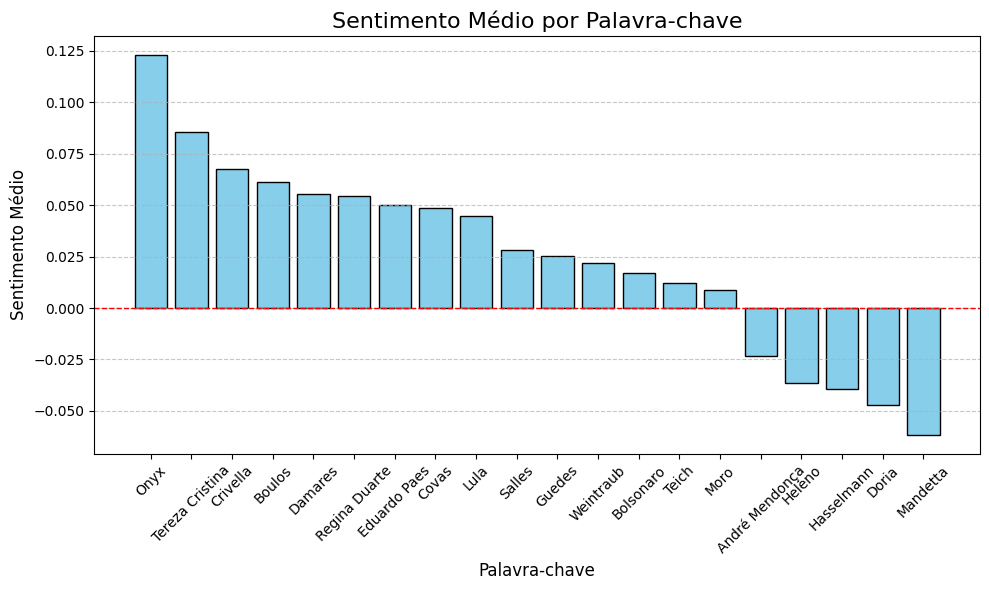

In [14]:
# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(sentiment_df['Keyword'], sentiment_df['AverageSentiment'],
        color='skyblue', edgecolor='black')

# Linha de referência no zero
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Personalizar o gráfico
plt.title('Sentimento Médio por Palavra-chave', fontsize=16)
plt.xlabel('Palavra-chave', fontsize=12)
plt.ylabel('Sentimento Médio', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar layout e mostrar o gráfico
plt.tight_layout()
plt.show()


In [15]:
data

,headlinePortuguese,sentimentScorePortuguese,keywords,website,sentimentMagnitudePortuguese,political_spectrum
0,Bolsonaro se desculpa após mandar repórter 'ca...,0.0,[Bolsonaro],UOL,0.0,Direita
1,"“Bolsonaro, faça um exame de consciência”",0.1,[Bolsonaro],O Antagonista,0.1,Direita
2,Moro dá 'unfollow' em Bolsonaro em rede social...,0.0,"[Bolsonaro, Moro]",G1,0.0,Direita
3,Inquérito que investiga Bolsonaro adota 'sabat...,0.1,[Bolsonaro],Folha de SP,0.1,Direita
4,Weintraub defendeu prisão para 'vagabundos' e ...,0.1,[Weintraub],R7,0.1,Direita
...,...,...,...,...,...,...
9022,Bolsonaro sanciona Nova Embratur e veta incent...,0.4,[Bolsonaro],R7,0.4,Direita
9023,Bolsonaro diz que estuda pagar mais 3 parcelas...,-0.1,[Bolsonaro],G1,0.1,Direita
9024,Mulher cobra Bolsonaro sobre '38.406 mortos po...,-0.1,[Bolsonaro],G1,0.1,Direita
9025,Deputado quer impugnar eventual indicação de W...,0.2,[Weintraub],O Antagonista,0.2,Direita


In [16]:
# Pré-processamento
data = data[['headlinePortuguese', 'sentimentScorePortuguese','website']].dropna().reset_index(drop=True)
data['label'] = data['sentimentScorePortuguese'].apply(lambda x: 1 if x > 0 else 0)

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(
    data['headlinePortuguese'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

# Configurações do modelo
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 5

# Tokenização
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(
    X_train.values.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

test_encodings = tokenizer(
    X_test.values.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Dataset e DataLoader
class HeadlineDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HeadlineDataset(train_encodings, y_train)
test_dataset = HeadlineDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

# Otimização
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Treinamento com barra de progresso
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_loader)
    print(f"Época {epoch+1} - Perda média: {avg_loss:.4f}")

# Avaliação
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testando"):
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(batch['labels'].cpu().numpy())

print("\nMétricas finais:")
print(f"Acurácia: {accuracy_score(true_labels, predictions):.4f}")
print(classification_report(true_labels, predictions))

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 452/452 [00:44<00:00, 10.25it/s, loss=0.206]


Época 1 - Perda média: 0.5483


Epoch 2/5: 100%|██████████| 452/452 [00:43<00:00, 10.40it/s, loss=0.12]  


Época 2 - Perda média: 0.3575


Epoch 3/5: 100%|██████████| 452/452 [00:43<00:00, 10.46it/s, loss=0.0114]


Época 3 - Perda média: 0.2264


Epoch 4/5: 100%|██████████| 452/452 [00:43<00:00, 10.40it/s, loss=0.00616]


Época 4 - Perda média: 0.1528


Epoch 5/5: 100%|██████████| 452/452 [00:43<00:00, 10.40it/s, loss=0.00297]


Época 5 - Perda média: 0.0997


Testando: 100%|██████████| 113/113 [00:02<00:00, 41.56it/s]



Métricas finais:
Acurácia: 0.8140
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1028
           1       0.80      0.76      0.78       778

    accuracy                           0.81      1806
   macro avg       0.81      0.81      0.81      1806
weighted avg       0.81      0.81      0.81      1806



In [17]:
# Função para prever o sentimento de uma nova manchete
def predict_sentiment(text, model, tokenizer, device):
    # Tokenização
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    
    # Previsão
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Converter logits em probabilidades
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# Nova manchete para teste
nova_manchete = ["Bolsonaro defende nova reforma política"]

# Executar previsão
probabilidades = predict_sentiment(nova_manchete, model, tokenizer, device)

# Interpretar resultados
classes = ["Negativo/Neutro (0)", "Positivo (1)"]
predicao = np.argmax(probabilidades)
confianca = probabilidades[0][predicao]

print(f"Manchete: '{nova_manchete[0]}'")
print(f"Predição: {classes[predicao]} (Confiança: {confianca:.4f})")
print(f"Distribuição completa: {probabilidades[0]}")

Manchete: 'Bolsonaro defende nova reforma política'
Predição: Negativo/Neutro (0) (Confiança: 0.9854)
Distribuição completa: [0.9853645  0.01463545]


##!pip freeze: lista todas as bibliotecas e suas versões.

##!pip show <biblioteca>: mostra detalhes de uma biblioteca específica.


In [ ]:
!pip freeze

In [ ]:
!pip show pandas scikit-learn nltk jinja2 matplotlib